In [1]:
import numpy as np
import matplotlib.pyplot as plt

from lindhard import par_eigh, calc_chi0, calc_chi0_band, calc_chi0_allorb, calc_chi0_orbij

In [2]:
# tight-binding model of https://www.sciencedirect.com/science/article/abs/pii/S0368204813001655
# all units in eV
def calc_ek(kz, ky, kx, t1=0.145, t2=0.016, t3=0.081, t4=0.039, t5=0.005, lamb=0.032, mu=0.122, s=1, n_threads=1):
    cx = np.cos(2*np.pi * kx)
    cy = np.cos(2*np.pi * ky)
    c2x = np.cos(2*np.pi * 2*kx)
    c2y = np.cos(2*np.pi * 2*ky)

    e_yz = -2*t2*cx - 2*t1*cy
    e_xz = -2*t1*cx - 2*t2*cy
    e_xy = -2*t3*(cx + cy) - 4*t4*cx*cy - 2*t5*(c2x + c2y)

#     A = np.array(
#         [[e_yz - mu, 1j*s*lamb, -s*lamb],
#         [-1j*s*lamb, e_xz - mu, 1j*lamb],
#         [-s*lamb,    -1j*lamb,  e_xy - mu]])

    # same as commented block above, but works even if ky, kx are arrays
    z = 0*kz + 0*ky + 0*kx
    A = np.stack(
        [[z + e_yz - mu,    z + 1j*s*lamb, z - s*lamb],
        [z - 1j*s*lamb,     z + e_xz - mu, z + 1j*lamb],
        [z - s*lamb,        z - 1j*lamb,   z +e_xy - mu]])
    A = np.ascontiguousarray(np.moveaxis(A, (0, 1), (-2, -1)))
    return par_eigh(A, n_threads=n_threads)

In [3]:
Lz, Ly, Lx = 1, 500, 500
kzs = np.linspace(0, 1, Lz, endpoint=False)
kys = np.linspace(0, 1, Ly, endpoint=False)
kxs = np.linspace(0, 1, Lx, endpoint=False)  # r.l.u.

In [4]:
ws = np.linspace(0, 0.7, 701)
gamma = 0.003
nq = 101
qs = np.zeros((nq, 3), dtype=np.int32)
qs[:, 0] = np.arange(nq) # increment along b1

In [5]:
%time ek, Ukdag = calc_ek(kzs[:, None, None], kys[:, None], kxs, n_threads=8)

CPU times: user 312 ms, sys: 8.8 ms, total: 321 ms
Wall time: 53.5 ms


In [6]:
%time chi0 = calc_chi0(qs, ws, gamma, ek, Ukdag, np.zeros((3, 3)), n_threads=8)

CPU times: user 1.03 s, sys: 4.03 ms, total: 1.03 s
Wall time: 135 ms


In [7]:
%time chi0_band = calc_chi0_band(qs, ws, gamma, ek, Ukdag, np.zeros((3, 3)), n_threads=8)

CPU times: user 16.9 s, sys: 20.6 ms, total: 17 s
Wall time: 2.37 s


In [8]:
%time chi0_allorb = calc_chi0_allorb(qs, ws, gamma, ek, Ukdag, np.zeros((3, 3)), n_threads=8)

CPU times: user 4min 26s, sys: 1.31 s, total: 4min 28s
Wall time: 37.6 s


In [9]:
%time chi0_orb11 = calc_chi0_orbij(qs, ws, gamma, ek, Ukdag, np.zeros((3, 3)), 1, 1, n_threads=8)

CPU times: user 29.7 s, sys: 638 ms, total: 30.4 s
Wall time: 4.34 s


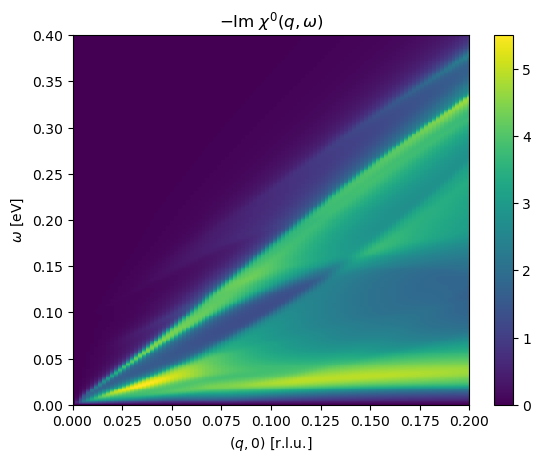

In [10]:
import matplotlib.pyplot as plt
# grid([0,1,2,3,4]) == -0.5, 0.5, 1.5, 2.5, 3.5, 4.5
def grid(x):
    dx = x[1] - x[0]
    return np.linspace(x[0] - dx/2, x[-1] + dx/2, len(x) + 1)
plt.pcolormesh(grid(qs[:, 0]/Lx), grid(ws), -chi0.imag.T, rasterized=True)
plt.xlim(0, (nq-1)/Lx)
plt.ylim(0, 0.4)
plt.ylabel(r"$\omega$ [eV]")
plt.xlabel("$(q, 0)$ [r.l.u.]")
plt.title(r"$-\text{Im }\chi^0(q,\omega)$")
plt.colorbar()
plt.show()

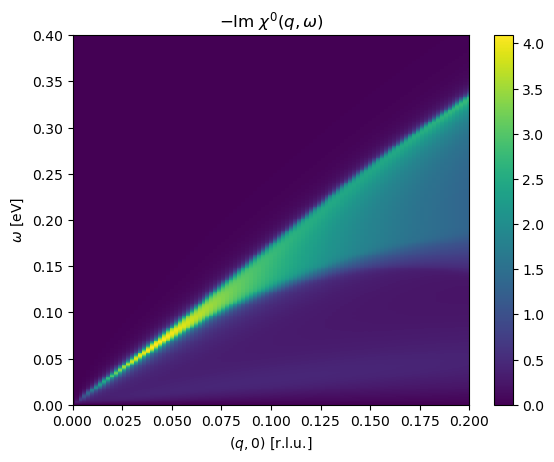

In [11]:
import matplotlib.pyplot as plt
# grid([0,1,2,3,4]) == -0.5, 0.5, 1.5, 2.5, 3.5, 4.5
def grid(x):
    dx = x[1] - x[0]
    return np.linspace(x[0] - dx/2, x[-1] + dx/2, len(x) + 1)
plt.pcolormesh(grid(qs[:, 0]/Lx), grid(ws), -chi0_band[2,2].imag.T, rasterized=True)
plt.xlim(0, (nq-1)/Lx)
plt.ylim(0, 0.4)
plt.ylabel(r"$\omega$ [eV]")
plt.xlabel("$(q, 0)$ [r.l.u.]")
plt.title(r"$-\text{Im }\chi^0(q,\omega)$")
plt.colorbar()
plt.show()

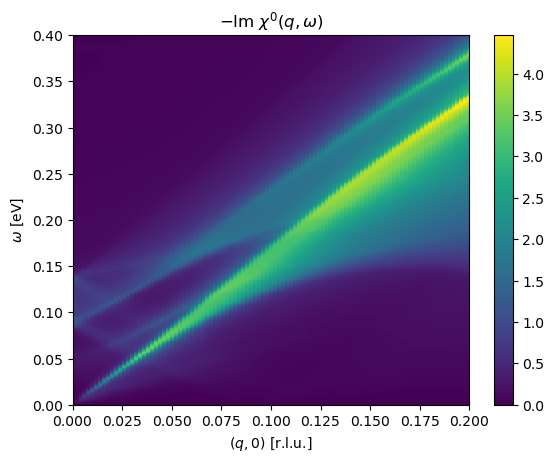

In [12]:
import matplotlib.pyplot as plt
# grid([0,1,2,3,4]) == -0.5, 0.5, 1.5, 2.5, 3.5, 4.5
def grid(x):
    dx = x[1] - x[0]
    return np.linspace(x[0] - dx/2, x[-1] + dx/2, len(x) + 1)
plt.pcolormesh(grid(qs[:, 0]/Lx), grid(ws), -chi0_orb11.imag.T, rasterized=True)
plt.xlim(0, (nq-1)/Lx)
plt.ylim(0, 0.4)
plt.ylabel(r"$\omega$ [eV]")
plt.xlabel("$(q, 0)$ [r.l.u.]")
plt.title(r"$-\text{Im }\chi^0(q,\omega)$")
plt.colorbar()
plt.show()